# COST - A <ins>CO</ins>VID-19 <ins>S</ins>EVERITY PREDICTION <ins>T</ins>OOL
### (COVID-19 Triage Tool)


In [214]:
## Libraries
library(Seurat)
library(tidyverse)

## Sections
#### &nbsp;&nbsp;&nbsp;&nbsp; 1) Read .h5 files and subset NK cells
#### &nbsp;&nbsp;&nbsp;&nbsp; 2) Quality Control
#### &nbsp;&nbsp;&nbsp;&nbsp; 3) Anchor based Integration
#### &nbsp;&nbsp;&nbsp;&nbsp; 4) Visualization on Heatmaps and Violin plots and Severity Prediction

#### 1) Reading .h5 files

In [215]:
##### 1.1) Read .h5 matricies and set-up seurat object

reference = readRDS("C:/Users/Mariam/Downloads/8803_project/berlin_bonn_merged_mildvssevere_dataset.rds")

filepaths = read.table("C:/Users/Mariam/Downloads/8803_project/filepaths.txt")
obj.gse = vector(mode = "list", length = 2)

obj.gse[[1]] = Read10X_h5(filepaths[1, ])

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [216]:
##### Function to check if the input file has Antibody capture data along with the Expression data

check <- function(x) {
    tryCatch(
    expr = {
        obj.gse[[1]] = obj.gse[[1]]$'Gene Expression' # select only gene expression data
    },
    error = function(x) {
        return(obj.gse[[1]])
    } 
    )
}

In [217]:
obj.gse[[1]] = check(obj.gse[[1]]) # Calling the check()

obj.gse[[1]] = CreateSeuratObject(counts = obj.gse[[1]], project = "input_sample", min.cells = 3, min.features = 200)
obj.gse[[1]][["percent.mt"]] <- PercentageFeatureSet(obj.gse[[1]], pattern = "^MT-") # calculate percentage mitochondrial count for each cell in each file simultaneously

obj.gse[[2]] = reference

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [218]:
obj.gse

[[1]]
An object of class Seurat 
14436 features across 8545 samples within 1 assay 
Active assay: RNA (14436 features, 0 variable features)

[[2]]
An object of class Seurat 
53955 features across 1494 samples within 8 assays 
Active assay: RNA (53916 features, 2000 variable features)
 7 other assays present: HTO, HTOsPool1, HTOsPool2, HTOsPool3, HTOsPool4, HTOsPool5, HTOsPool6
 2 dimensional reductions calculated: pca, umap


In [219]:
##### 1.2) Subset NK cells
obj.gse[[1]] = subset(obj.gse[[1]], (NCAM1 > 0) & (GNLY > 0) & (NKG7 > 0) & (KLF2 > 0) , slot = "data")
obj.gse[[1]]

###### Stop the script if number of cells after subsetting are less than 30
if (ncol(obj.gse[[1]]) < 30) {
    stop("Number of Cells less than 30")
}

An object of class Seurat 
14436 features across 283 samples within 1 assay 
Active assay: RNA (14436 features, 0 variable features)

#### 2) Quality Control

In [220]:
# if there is an error: Error in file(con, "rb"): cannot open the connection
# dir.create(tempdir())

png 
  2

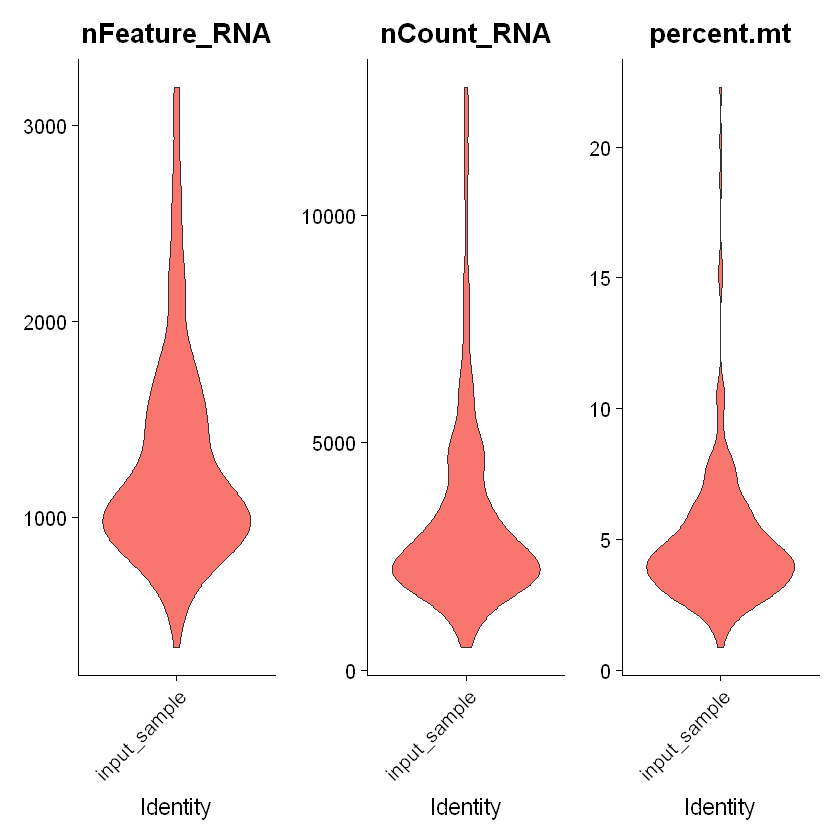

In [221]:
##### 2.1) Check nFeature_RNA, nCount_RNA, and percent.mt for each dataset

pdf("C:/Users/Mariam/Downloads/8803_project/plots/BeforeQC.pdf")
p1 = VlnPlot(obj.gse[[1]], features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0) 
dev.off()

print(p1)

In [222]:
##### 2.2) Filter based on nFeature_RNA,and percent.mt for each dataset

obj.gse[[1]]= subset(obj.gse[[1]], subset = nFeature_RNA > 200 & nFeature_RNA < 2400 & percent.mt < 20)

png 
  2

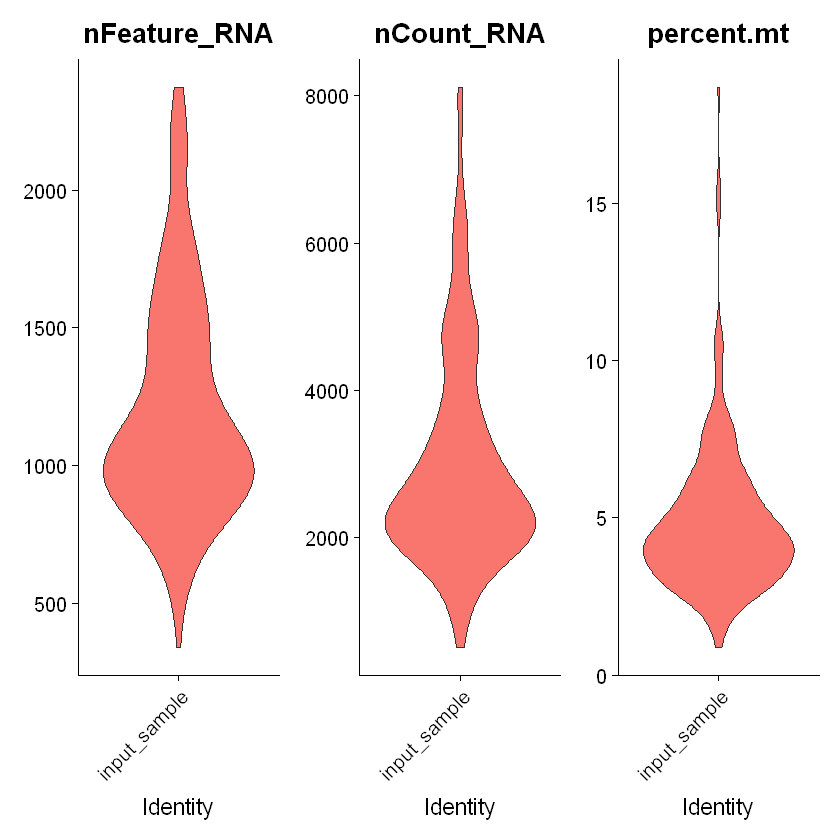

In [223]:
##### 2.3) Check the quality (nFeature_RNA, nCount_RNA, and percent.mt) after filtering  

pdf("C:/Users/Mariam/Downloads/8803_project/plots/AfterQC.pdf")
p1 = VlnPlot(obj.gse[[1]], features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0) 
dev.off()

print(p1)

#### 3) Anchor based Integration

In [224]:
##### 3.1) Normalize and identify variable features for input dataset

obj.gse[[1]] <- NormalizeData(obj.gse[[1]])
obj.gse[[1]] <- FindVariableFeatures(obj.gse[[1]], selection.method = "vst", nfeatures = 2000)

In [225]:
##### 3.2) Select features that are repeatedly variable across datasets for integration

features <- SelectIntegrationFeatures(object.list = obj.gse)

In [226]:
##### 3.3) Perform Integration

anchors = FindIntegrationAnchors(object.list = obj.gse, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1321 anchors

Filtering anchors

	Retained 466 anchors



In [227]:
##### 3.4) Create an 'integrated' data assay

gse <- IntegrateData(anchorset = anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [228]:
##### 3.5) Perform integrated analysis
###### 3.5.1) Specify that we will perform downstream analysis on the corrected data. (Note that the original unmodified data still resides in the 'RNA' assay)
DefaultAssay(gse) <- "integrated"

###### 3.5.2) Visualization and clustering
gse <- ScaleData(gse, features = rownames(gse), verbose = FALSE)
gse <- RunPCA(gse, verbose = FALSE)

png 
  2

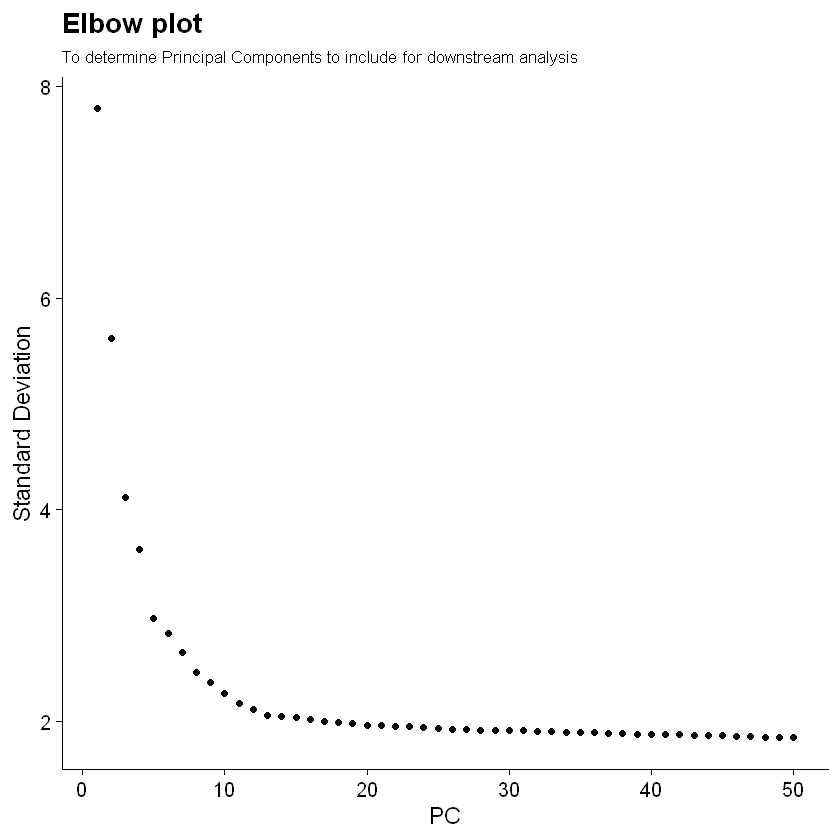

In [229]:
####### 3.5.2.1) Check how many PCs to include

pdf("C:/Users/Mariam/Downloads/8803_project/plots/ElbowPlot.pdf")
p1 = ElbowPlot(gse, ndims = 50) + labs(title ="Elbow plot", subtitle ="To determine Principal Components to include for downstream analysis") + theme(plot.title = element_text(size = 16), plot.subtitle = element_text(size = 10)) 
dev.off()
print(p1)

In [230]:
###### 3.5.2.2) Clustering

gse <- RunUMAP(gse, reduction = "pca", dims = 1:30)
gse <- FindNeighbors(gse, reduction = "pca", dims = 1:30)
gse <- FindClusters(gse, resolution = 0.5)

saveRDS(gse, "C:/Users/Mariam/Downloads/8803_project/pipeline_gse.Rds")

14:02:04 UMAP embedding parameters a = 0.9922 b = 1.112

14:02:04 Read 1761 rows and found 30 numeric columns

14:02:04 Using Annoy for neighbor search, n_neighbors = 30

14:02:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:02:05 Writing NN index file to temp file C:\Users\Mariam\AppData\Local\Temp\Rtmpspn8Fc\file82b85a8930cf

14:02:05 Searching Annoy index using 1 thread, search_k = 3000

14:02:05 Annoy recall = 100%

14:02:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:02:06 Initializing from normalized Laplacian + noise (using irlba)

14:02:06 Commencing optimization for 500 epochs, with 72714 positive edges

14:02:13 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1761
Number of edges: 83412

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8015
Number of communities: 7
Elapsed time: 0 seconds


In [231]:
gse$all = "all"
gse$dataType = "reference"
gse$dataType[gse$orig.ident == "input_sample"] = "input"

In [232]:
head(gse, 1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_HTO,nFeature_HTO,percent.mito,HTO_maxID,HTO_secondID,HTO_margin,⋯,nFeature_HTOsPool6,RNA_snn_res.0.6,RNA_snn_res.2,RNA_snn_res.1.5,disease_status,subtype_new,RNA_snn_res.0.1,integrated_snn_res.0.5,all,dataType
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
AAAGATGTCTTACCTA-1,input_sample,2125,993,4.047059,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,3,all,input


In [233]:
head(obj.gse[[2]], 2)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,percent.mito,HTO_maxID,HTO_secondID,HTO_margin,HTO_classification,⋯,nCount_HTOsPool5,nFeature_HTOsPool5,nCount_HTOsPool6,nFeature_HTOsPool6,RNA_snn_res.0.6,RNA_snn_res.2,RNA_snn_res.1.5,disease_status,subtype_new,RNA_snn_res.0.1
,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
bonn_AGCACACAGAGGCAGCTAATATTGTAA_1,200416_cartridge_1,2014,1038,17,5,9.433962,SampleTag10,SampleTag2,0.0857791,SampleTag10,⋯,0,0,0,0,NA,NA,NA,NA,NA,0
bonn_CCACTTGGAGACACTTAACAGGCATTT_1,200416_cartridge_1,2352,1241,10,5,8.758503,SampleTag7,SampleTag9,0.5241661,SampleTag7,⋯,0,0,0,0,NA,NA,NA,NA,NA,0


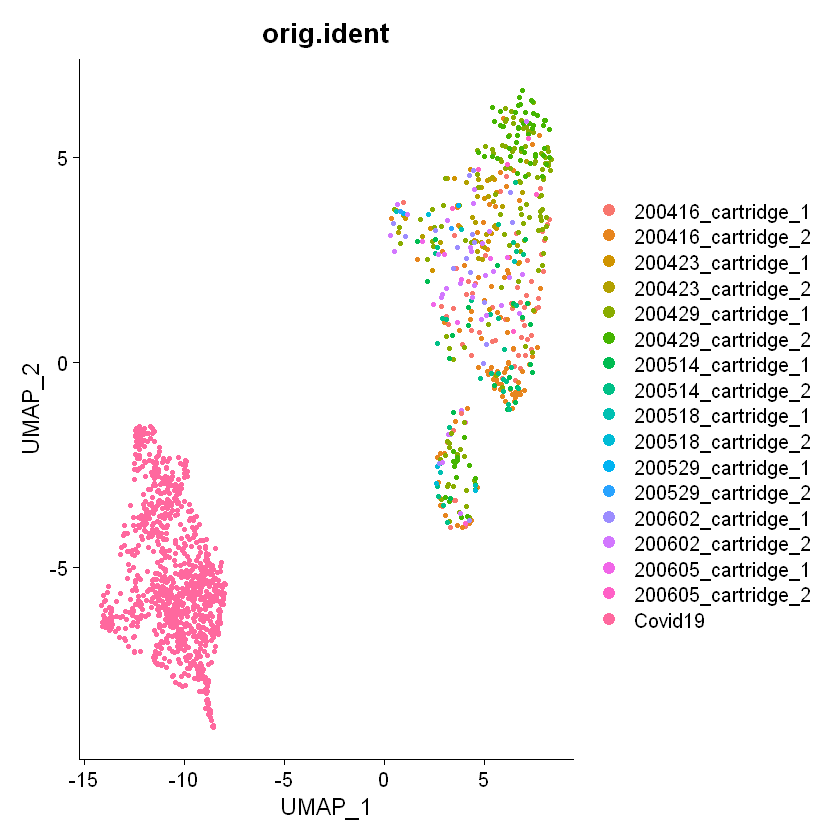

In [234]:
DimPlot(obj.gse[[2]], reduction = "umap", group.by = "orig.ident") #reference dataset on umap

png 
  2

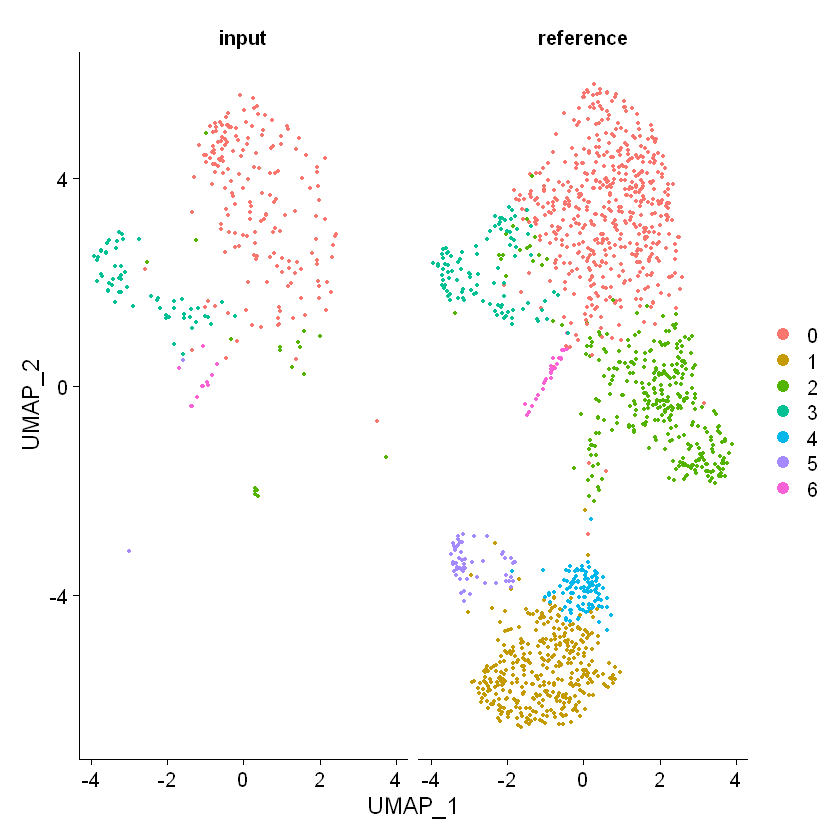

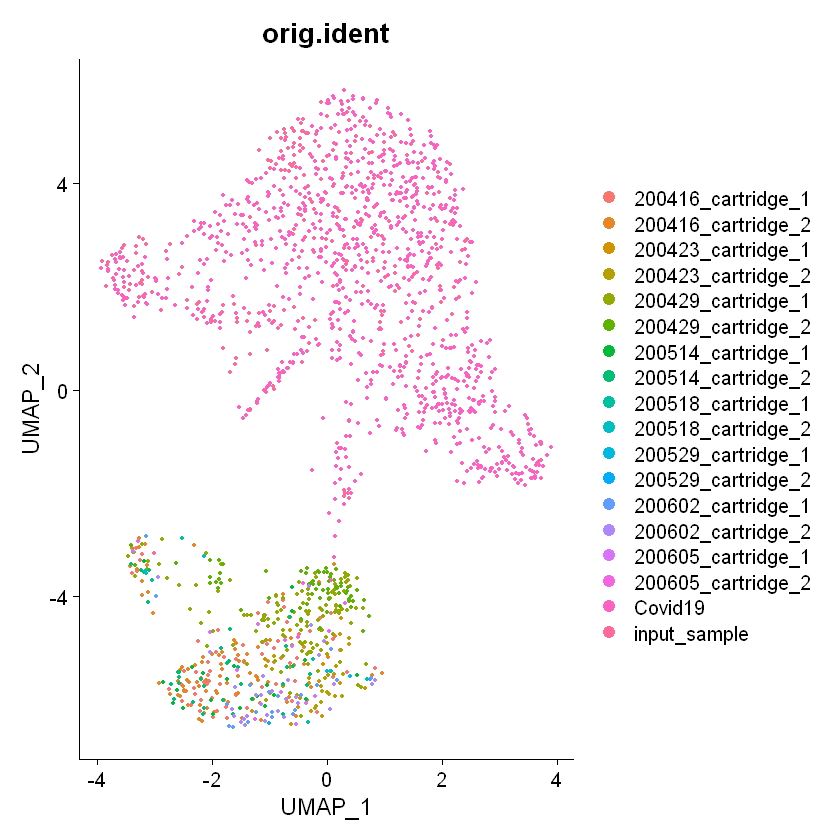

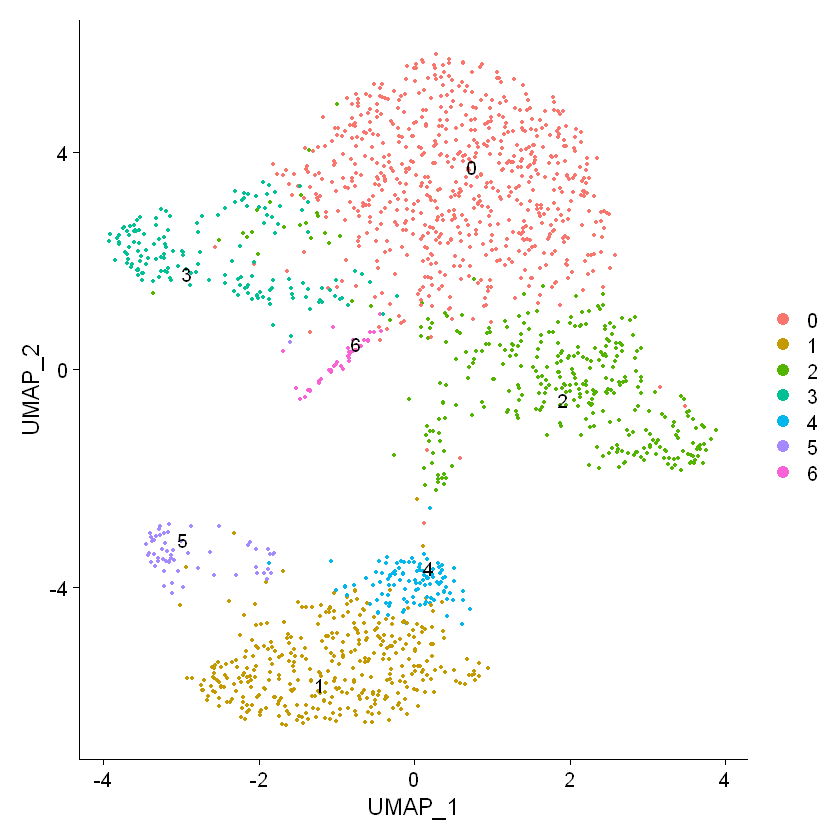

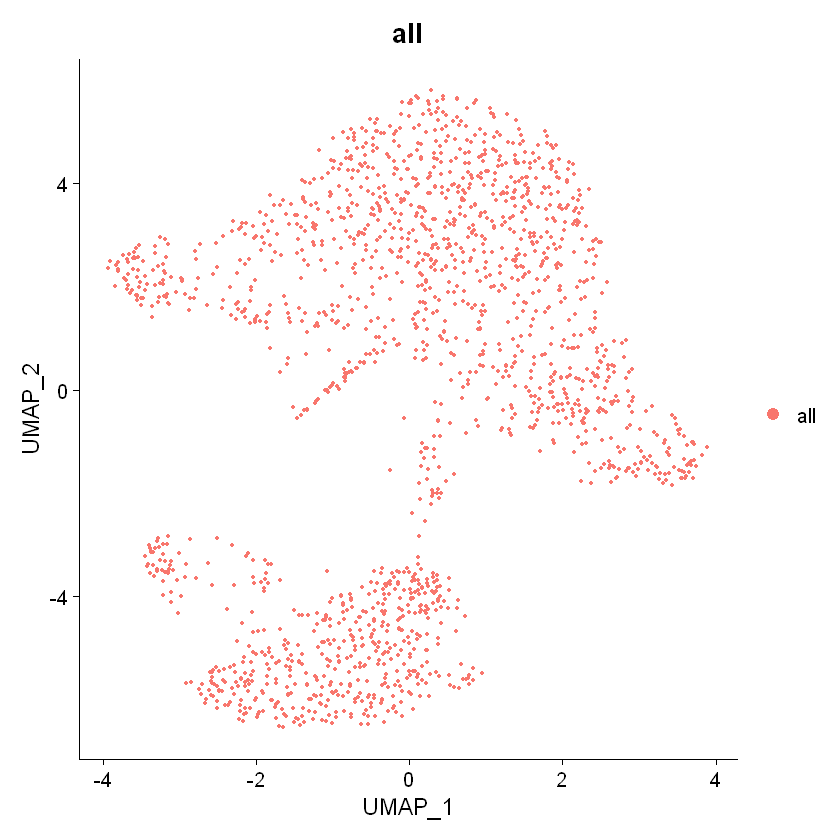

In [235]:
####### 3.5.2.3) Visualization

pdf("C:/Users/Mariam/Downloads/8803_project/plots/UMAP.pdf")
Idents(gse) = "seurat_clusters"
p1 = DimPlot(gse, reduction = "umap", split.by = "dataType")
p2 = DimPlot(gse, reduction = "umap", group.by = "orig.ident")
p3 = DimPlot(gse, reduction = "umap", label = TRUE, repel = TRUE)
p4 = DimPlot(gse, reduction = "umap", group.by = "all")

dev.off()

print(p1)
print(p2)
print(p3)
print(p4)

#### 4) Visualization on Heatmaps and Violin plots and Severity Prediction

In [236]:
##### 4.1) Scale RNA Assay Data for Heatmaps

gse = ScaleData(gse, features = rownames(gse), assay="RNA", verbose = FALSE)

Warning message in DoHeatmap(gse, features = severe_markers, raster = F, size = 4, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: MT-ND2, MT-RNR2, IGKC"
Warning message in DoHeatmap(gse, features = mild_markers, raster = F, size = 4, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: ATP5F1E, SLFN5"


png 
  2

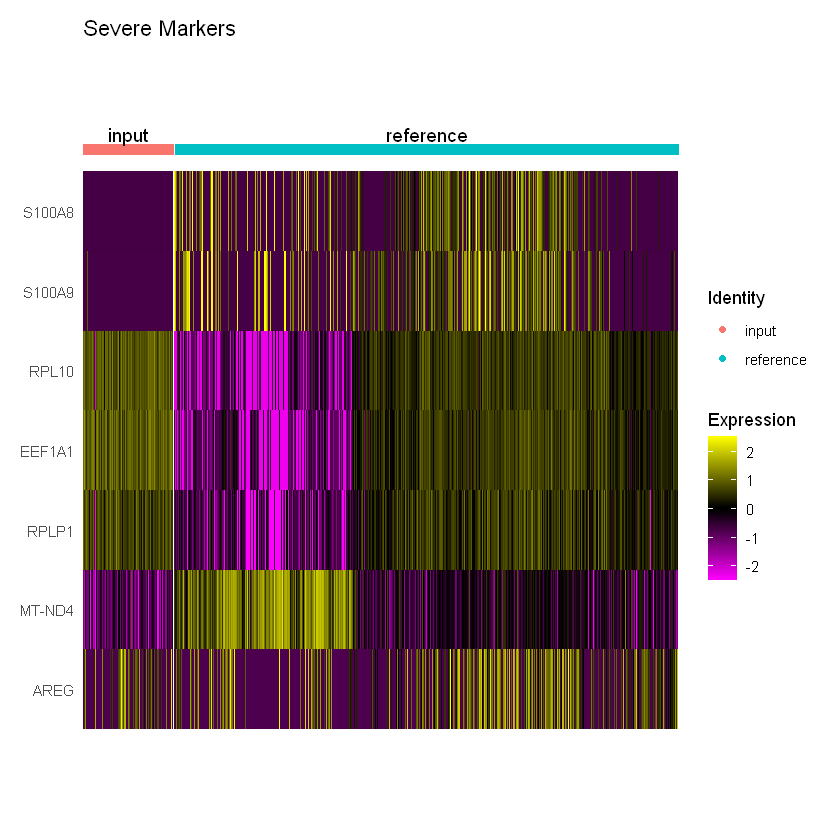

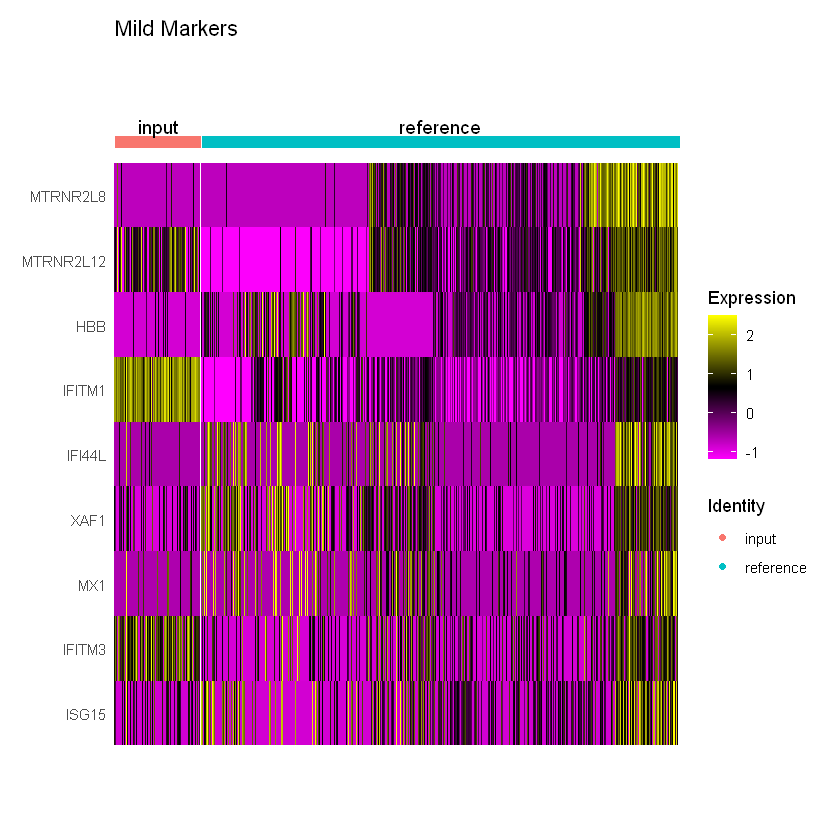

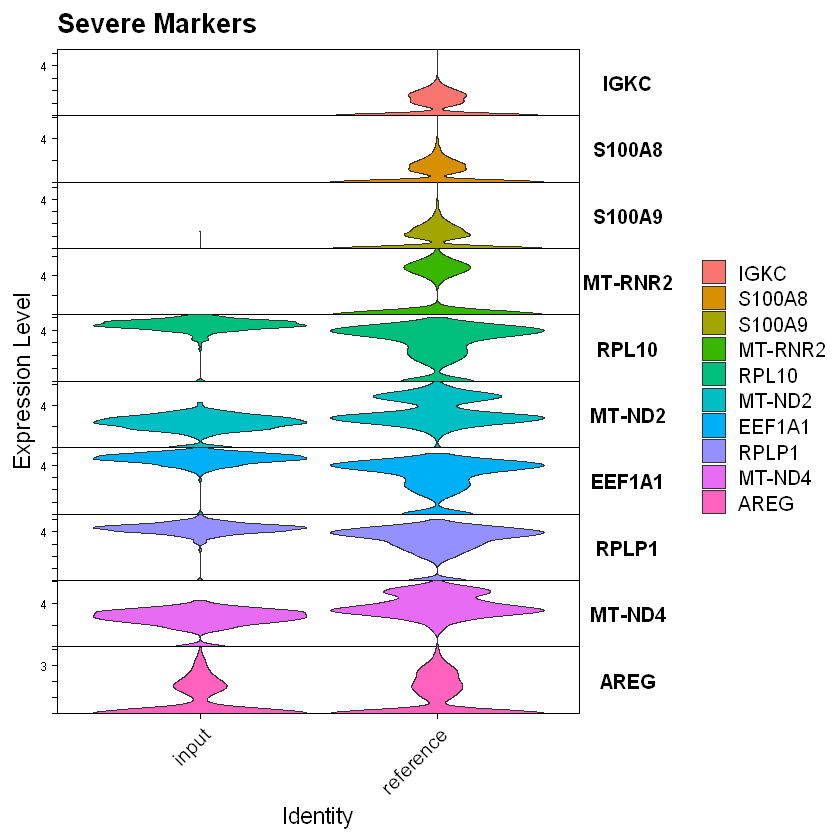

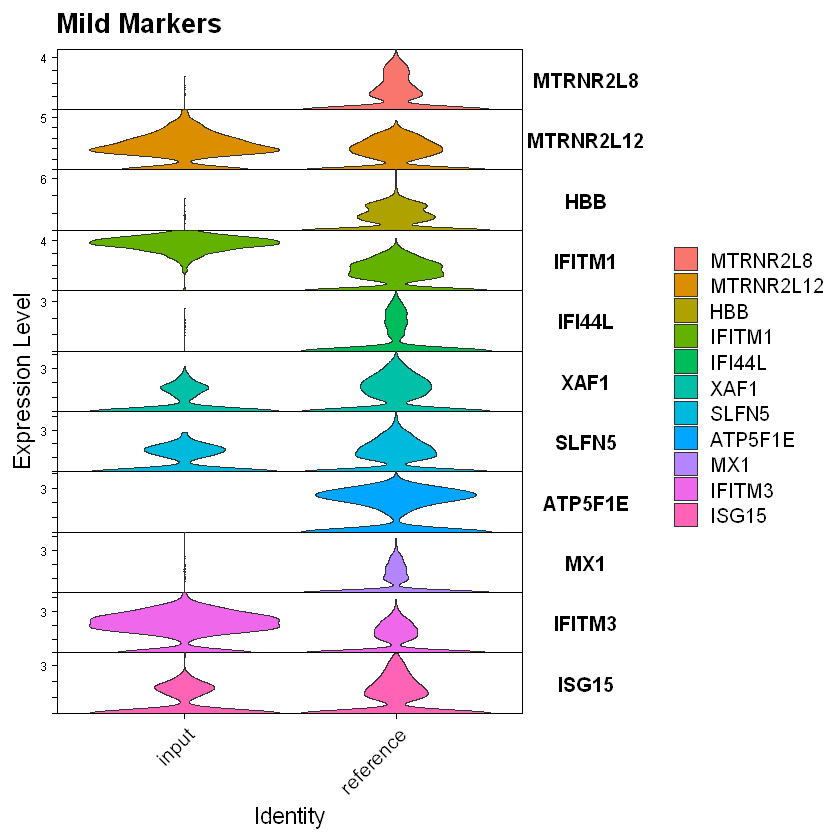

In [237]:
##### 4.2) Plot severe and mild markers on the input dataset and display as Heatmaps and Violin plots

Idents(gse) = "dataType"
DefaultAssay(gse) = "RNA"

severe_markers = c("IGKC","S100A8","S100A9","MT-RNR2","RPL10","MT-ND2","EEF1A1","RPLP1","MT-ND4","MT-ND2","AREG","MT-RNR2") 
mild_markers = c("MTRNR2L8","MTRNR2L12","HBB","IFITM1","IFI44L","XAF1","SLFN5","ATP5F1E","MX1","IFITM3","ISG15")

pdf(file = "C:/Users/Mariam/Downloads/8803_project/plots/pipeline_markers_HeatMaps.pdf")
p1 = DoHeatmap(gse, features=severe_markers, raster = F, size=4, angle=0, hjust=0.5) + ggtitle("Severe Markers")
p2 = DoHeatmap(gse, features=mild_markers, raster = F, size=4, angle=0, hjust=0.5) + ggtitle("Mild Markers")

p3 = VlnPlot(gse, features = severe_markers, pt.size = 0, slot="data", stack = TRUE, flip = TRUE) + ggtitle("Severe Markers")
p4 = VlnPlot(gse, features = mild_markers, pt.size = 0, slot="data", stack = TRUE, flip = TRUE) + ggtitle("Mild Markers")

dev.off()

print(p1)
print(p2)
print(p3)
print(p4)

In [238]:
##### 4.3) Calculate expression of Markers in the input dataset

Idents(gse) = "dataType"
avg_exp_severe = data.frame(AverageExpression(gse, features = severe_markers, slot = "data", assay = "RNA"))
avg_exp_mild = data.frame(AverageExpression(gse, features = mild_markers, slot = "data", assay = "RNA"))


###### Adding Gene names as a column
avg_exp_severe$gene_name = rownames(avg_exp_severe)
avg_exp_mild$gene_name = rownames(avg_exp_mild)

avg_exp_severe
avg_exp_mild

,RNA.input,RNA.reference,gene_name
,<dbl>,<dbl>,<chr>
IGKC,0.00000000,2.172079,IGKC
S100A8,0.00000000,2.835163,S100A8
S100A9,0.01131174,2.363180,S100A9
MT-RNR2,0.00000000,54.486862,MT-RNR2
RPL10,84.77154322,36.192226,RPL10
MT-ND2,11.11302035,60.440300,MT-ND2
EEF1A1,102.60385324,38.636056,EEF1A1
RPLP1,75.41666976,40.208958,RPLP1
MT-ND4,17.35090779,72.108706,MT-ND4


,RNA.input,RNA.reference,gene_name
,<dbl>,<dbl>,<chr>
MTRNR2L8,0.1847097,4.915662,MTRNR2L8
MTRNR2L12,16.3248604,7.340144,MTRNR2L12
HBB,0.4807991,9.870081,HBB
IFITM1,46.5912924,4.505480,IFITM1
IFI44L,0.3094182,2.430705,IFI44L
XAF1,1.5354574,4.521996,XAF1
SLFN5,1.9110385,3.772390,SLFN5
ATP5F1E,0.0000000,7.595340,ATP5F1E
MX1,0.8701129,1.906591,MX1


In [239]:
###### Create an empty dataframe to store markers and their expressions in the input data that cross the threshold 

sig_severe_markers_in_inputData = data.frame(matrix(ncol = 2, nrow = 0))
colnames(sig_severe_markers_in_inputData) = c("Gene_Name", "Expression")

sig_mild_markers_in_inputData = data.frame(matrix(ncol = 2, nrow = 0))
colnames(sig_mild_markers_in_inputData) = c("Gene_Name", "Expression")

In [240]:
###### Select Severe Markers present in the input data that cross the threshold

for (row in 1:nrow(avg_exp_severe)) {
    expression = avg_exp_severe[row, "RNA.input"]
    if (expression > 0.5) {
        sig_severe_markers_in_inputData[nrow(sig_severe_markers_in_inputData) + 1,] = 
        c(avg_exp_severe$gene_name[row], avg_exp_severe$RNA.input[row])
    }   
}

sig_severe_markers_in_inputData 

###### Save the expression values as a csv
write.csv(sig_severe_markers_in_inputData, "C:/Users/Mariam/Downloads/8803_project/tables/sig_severe_markers_in_inputData.csv")


,Gene_Name,Expression
,<chr>,<chr>
1,RPL10,84.7715432232273
2,MT-ND2,11.1130203529959
3,EEF1A1,102.603853243488
4,RPLP1,75.4166697629338
5,MT-ND4,17.3509077901172
6,AREG,2.83249510301686


In [241]:
###### Select Mild Markers present in the input data that cross the threshold

for (row in 1:nrow(avg_exp_mild)) {
    expression = avg_exp_mild[row, "RNA.input"]
    if (expression > 0.5) {
        sig_mild_markers_in_inputData[nrow(sig_mild_markers_in_inputData) + 1,] = 
        c(avg_exp_mild$gene_name[row], avg_exp_mild$RNA.input[row])
    }   
}

sig_mild_markers_in_inputData 

###### Save the expression values as a csv
write.csv(sig_mild_markers_in_inputData, "C:/Users/Mariam/Downloads/8803_project/tables/sig_mild_markers_in_inputData.csv")


,Gene_Name,Expression
,<chr>,<chr>
1,MTRNR2L12,16.324860379947
2,IFITM1,46.5912924242293
3,XAF1,1.53545742554959
4,SLFN5,1.91103849892194
5,MX1,0.870112929373503
6,IFITM3,8.80576959085331
7,ISG15,1.66421253630286


In [242]:
##### 4.4) Predict Severity

if (nrow(sig_severe_markers_in_inputData) > nrow(sig_mild_markers_in_inputData)) {
    prediction = "Severe"
} else if (nrow(sig_severe_markers_in_inputData) < nrow(sig_mild_markers_in_inputData)) {
    prediction = "Mild"
} else {
    prediction = "Moderate"
}

print(prediction)

[1] "Mild"
